In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import sklearn as sk

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.optimizers import Adam

import mlflow

#----------------------------
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)

2024-09-10 19:04:28.413250: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 19:04:28.426535: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 19:04:28.542983: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 19:04:28.648641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 19:04:28.743573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# Set graphs style

sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [3]:
# Loading the data

AAPLData = pd.read_hdf('../data/lSTMData/lSTMData.h5','AAPL')
AAPLData.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-04,23.777143,24.112143,23.732143,24.106071,20.444380,367892000
2012-09-05,24.127501,24.155357,23.914286,23.936787,20.300814,336375200
2012-09-06,24.041786,24.224644,23.957144,24.152500,20.483757,391196400
2012-09-07,24.216070,24.374287,24.134644,24.301430,20.610065,329666400
2012-09-10,24.301786,24.403214,23.646429,23.669287,20.073950,487998000


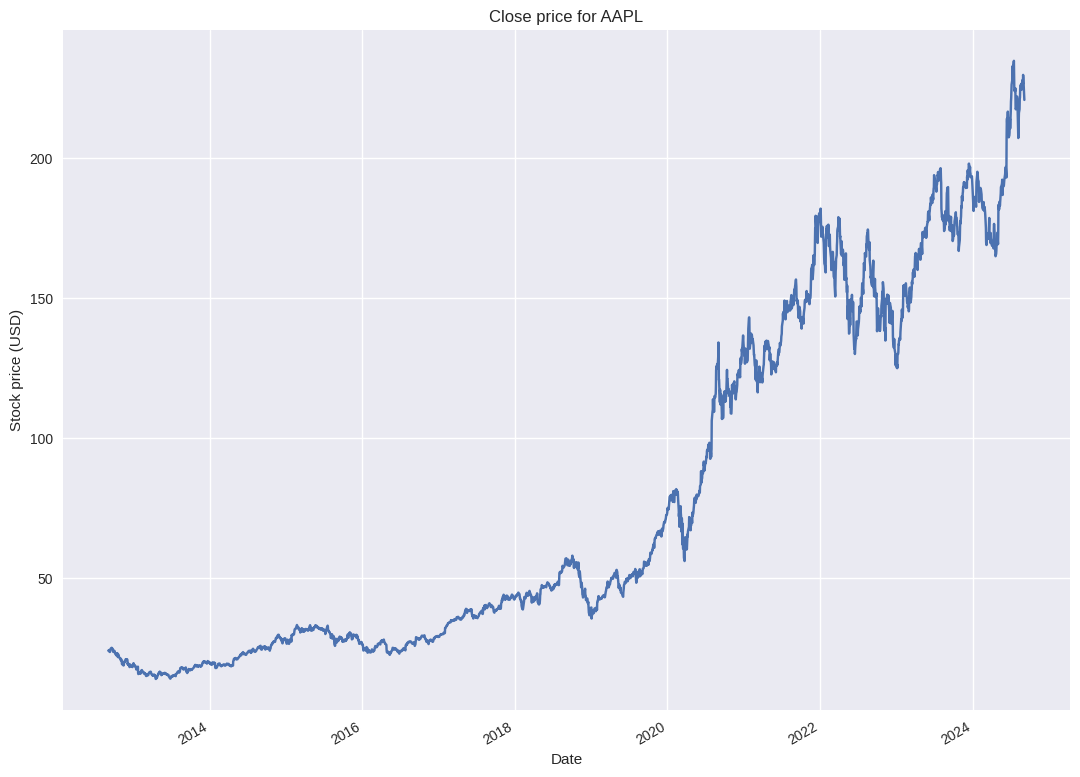

In [4]:
# Visualize the data

fig = plt.figure(figsize=(13,10))

AAPLData['Close'].plot()
plt.ylabel('Stock price (USD)')
plt.title('Close price for AAPL')
plt.show()

In [5]:
print(f"Tracking Server URI: '{mlflow.get_tracking_uri()}'")

Tracking Server URI: 'file:///home/sebastian/Desktop/For_studyng/Projects/StockMarket/model_generate/mlruns'


In [6]:
mlflow.end_run()

In [10]:

# Sequences for the LSTM
def sequences(data:np.ndarray, timeStep:int):
    x = []
    y = []
    
    for i in range(len(data) - timeStep):
        x.append(data[i:(i + timeStep)])
        y.append(data[i + timeStep])
    return np.array(x), np.array(y)
    
# Metric for the error    
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

# Function to run mlflow experiment
def run_experiment(data, trainDataPercentage:float, timeStep:int, epochs:int, batch_size:int,lr:float, run_name:str):
    
    # Scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    data = data[['Close']].values
    
    scaled_data = scaler.fit_transform(data)
    
    
    # take training data
    trainDataLen = int(len(data) * trainDataPercentage)
    trainData = scaled_data[:trainDataLen, 0]
    
    x_train, y_train = sequences(data=trainData,timeStep=timeStep)
    
    # Reshape data to train (samples, timeSteps, features)
    #x_train = x_train.reshape(trainDataLen, timeSteps, 1)
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
    
    # Create model
    model = Sequential()
    
    model.add(Input(shape=(timeStep, 1)))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(60, return_sequences=False))
    
    model.add(Dense(22))
    model.add(Dense(1))
    
    # Define hyperparams
    lr = lr
    optimizer = Adam(learning_rate=lr)
    epochs = epochs
    batch_size = batch_size
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # train model
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
    
    # Test model
    # Create training dataset
    testData = scaled_data[(trainDataLen - timeStep):,0]
    
    # Create testing sequences
    
    #y_test = data[trainDataLen:]
    x_test,y_test = sequences(data=testData,timeStep=timeStep)
    
    
    #                      (samples, timeSteps, features)
    #x_test = x_test.reshape(trainDataLen, timeSteps, 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    # Make predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_real = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Get RMSE
    rmseValue = rmse(y_true=y_real, y_pred=predictions)
    
    results_contrast = {
    'date':AAPLData.index[trainDataLen:],
    'predictions': predictions.reshape(-1),
    'real_values': y_real.reshape(-1)
    }

    trainInfo = pd.DataFrame(results_contrast)
    trainInfo.set_index('date', inplace=True)
    
    
    with mlflow.start_run(run_name= run_name): 
        
        mlflow.log_param('run name',run_name )
        
        mlflow.log_param('Train percentage', trainDataPercentage)
        mlflow.log_param('epohcs', epochs)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('Learning rate', lr)
        mlflow.log_metric('rmse', rmseValue)
        
        mlflow.sklearn.log_model(model, artifact_path='model')
    
    return rmseValue, trainInfo


In [11]:
mlflow.set_tracking_uri("file:/home/sebastian/Desktop/For_studyng/Projects/StockMarket/mlruns")
mlflow.set_experiment("LSTM_experiment_1")   

<Experiment: artifact_location='file:///home/sebastian/Desktop/For_studyng/Projects/StockMarket/mlruns/329117422173031513', creation_time=1725929359511, experiment_id='329117422173031513', last_update_time=1725929359511, lifecycle_stage='active', name='LSTM_experiment_1', tags={}>

In [32]:
# Run the experiment!

context = {
    'data': AAPLData,
    'trainDataPercentage':0.95,
    'timeStep':40, 
    'epochs':1,
    'batch_size':1,
    'lr':0.01,
    'run_name': 'LSTMStock6'
}


rmseValue, trainInfo = run_experiment(**context)
#rmseValue



2828/2828 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0113
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024/09/10 19:53:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [33]:
rmseValue

4.161075284000071

In [34]:
trainInfo

,predictions,real_values
date,,
2024-01-30,190.944656,188.039993
2024-01-31,187.750900,184.399994
2024-02-01,184.286499,186.860001
2024-02-02,184.820709,185.850006
2024-02-05,184.010117,187.679993
...,...,...
2024-08-28,222.871780,226.490005
2024-08-29,222.023895,229.789993
2024-08-30,224.081909,229.000000


In [13]:
experiment = mlflow.get_experiment_by_name("LSTM_experiment_1")
print(experiment)

<Experiment: artifact_location='file:///home/sebastian/Desktop/For_studyng/Projects/StockMarket/mlruns/329117422173031513', creation_time=1725929359511, experiment_id='329117422173031513', last_update_time=1725929359511, lifecycle_stage='active', name='LSTM_experiment_1', tags={}>


In [43]:
# Get the runs
runs = mlflow.search_runs(experiment_ids=experiment.experiment_id)

# Get the artifact uri
artifact_uri = runs['artifact_uri'][0]
artifact_uri

'file:///home/sebastian/Desktop/For_studyng/Projects/StockMarket/mlruns/329117422173031513/20014f4ba6e7408a835d0f7439d6c549/artifacts'

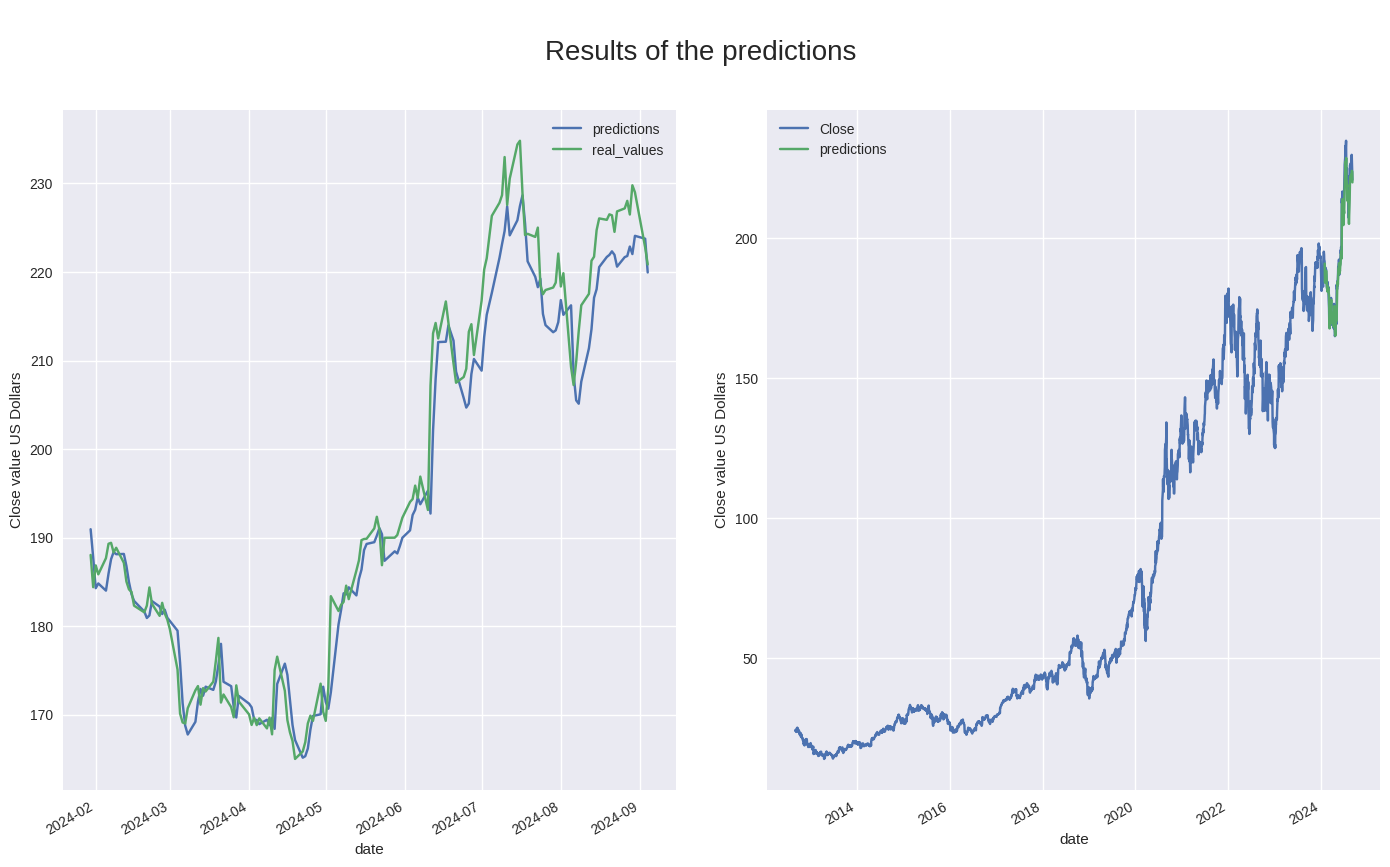

In [35]:
# Crear la figura y los subplots
fig, ax = plt.subplots(1, 2, figsize=(17, 10))
plt.subplots_adjust(hspace=0.35,wspace=0.15)

# Plot the both real and predicted values to compare
trainInfo.plot(ax=ax[0])
ax[0].set_ylabel('Close value US Dollars')

# Plot the total data vs the predicitons
AAPLData[['Close']].plot(ax=ax[1])  
trainInfo[['predictions']].plot(ax=ax[1])
ax[1].set_ylabel('Close value US Dollars')

plt.suptitle('\nResults of the predictions', fontsize=20)
plt.show()